<a href="https://colab.research.google.com/github/HimanshuSahoo/Arima-Model/blob/main/Book_recommendation_system_scraping%26predicting_books_Himanshu_Deployment_Ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
from time import time

#data processing libraries 

from sklearn import preprocessing

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')




#Evaluate the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [ ]:
#pip install tensorflow

In [ ]:
def get_page(url):
    page = requests.get(url)
    soup = bs(page.text,"lxml")
    return soup

In [ ]:
def get_links(soup):
    links=[]
    listings = soup.find_all('a' ,{'class' : 'bookTitle'})
    base_url="https://www.goodreads.com"
    for i in listings:
        book_link = i.get("href")
        complete_link  = base_url + book_link
        links.append(complete_link)
    return links

In [ ]:
#extract info from each link

def extract_info(links):
    for link in links:
        res = requests.get(link).text
        book_soup = bs(res,'html.parser')
        try:
            book_id = book_soup.find('div',{'id':'buyButtonContainer'}).get('data-book-id')
            title = book_soup.find('h1',{'id':"bookTitle"}).text.strip()
            author = book_soup.find('span',{'itemprop':"name"}).text.strip()
            average_rating = book_soup.find('span',{'itemprop':"ratingValue"}).text.strip()
            #description = book_soup.find('div',{'id':"description"}).text.strip()
            description = book_soup.find('div', {'id': "description"}).find_all('span')[1].text.strip()
            genre = book_soup.find('a',{'class':"actionLinkLite bookPageGenreLink"}).text.strip()
            book_image_url = book_soup.find('img', {'id': 'coverImage'}).get('src').strip()
            book_url = link
        except AttributeError:
            continue
        
        book = {'book_id':book_id,'title': title,'author': author,'average_rating':average_rating,'genre':genre,'description':description,'url':book_url,'image_url':book_image_url}
        all_books.append(book)
    return len(all_books)


In [ ]:
all_books = []
books  = pd.DataFrame()
for page in range(1,51):
    url = "https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page={}".format(page)
    soup = get_page(url)
    links = get_links(soup)
    (extract_info(links))


KeyboardInterrupt: 

In [ ]:
books = pd.DataFrame(all_books)

In [ ]:
books.to_csv('books_data_50.csv')

In [ ]:
books = pd.read_csv('books_data_40.csv')
books.drop('Unnamed: 0',axis = 1,inplace = True)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3352 entries, 0 to 3351
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3352 non-null   object 
 1   author          3352 non-null   object 
 2   average_rating  3352 non-null   float64
 3   genre           3352 non-null   object 
 4   description     3352 non-null   object 
dtypes: float64(1), object(4)
memory usage: 131.1+ KB


In [ ]:
#shape of the final dataframe
books.shape

(3352, 5)

## EDA

In [ ]:
#checking null values
books.isnull().sum()

title             0
author            0
average_rating    0
genre             0
description       0
dtype: int64

In [ ]:
#checking duplicate rows
books.duplicated().sum()

16

In [ ]:
#dropping duplicates
books.drop_duplicates(keep = 'first',inplace = True)

In [ ]:
#check value count by genre
books.genre.value_counts()

Fiction             802
Nonfiction          391
Fantasy             324
Classics            302
Young Adult         182
                   ... 
Literary Fiction      1
Design                1
Food and Drink        1
Occult                1
Magical Realism       1
Name: genre, Length: 77, dtype: int64

### Distribution of data by Genre

<AxesSubplot:>

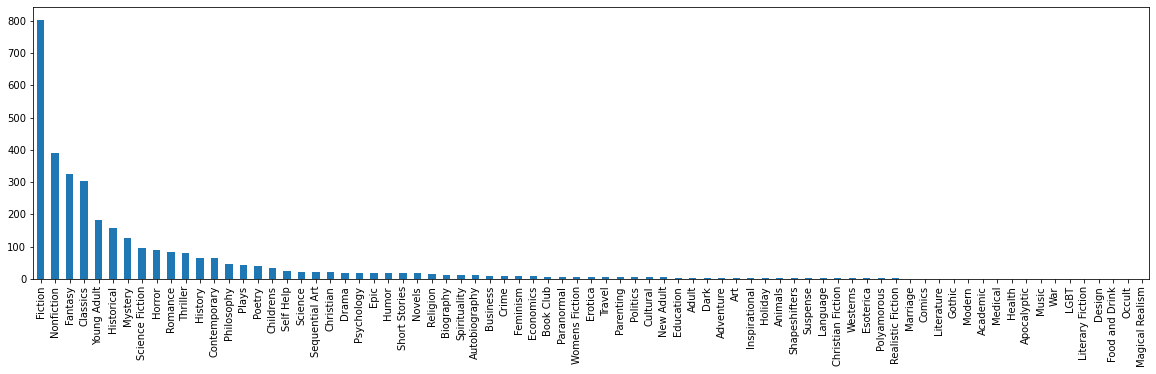

In [ ]:
books['genre'].value_counts().plot(x='genre',y = 'count',kind = 'bar',figsize = (20,5))

The data is quite unbalanced. we will consider the first six categories for the final analysis.

In [ ]:
#print the title and description of a random sample

print(books['title'][10])
books['description'][10]

Romeo and Juliet


'In Romeo and Juliet, Shakespeare creates a violent world, in which two young people fall in love. It is not simply that their families disapprove; the Montagues and the Capulets are engaged in a blood feud.In this death-filled setting, the movement from love at first sight to the lovers’ final union in death seems almost inevitable. And yet, this play set in an extraordina\nIn Romeo and Juliet, Shakespeare creates a violent world, in which two young people fall in love. It is not simply that their families disapprove; the Montagues and the Capulets are engaged in a blood feud.In this death-filled setting, the movement from love at first sight to the lovers’ final union in death seems almost inevitable. And yet, this play set in an extraordinary world has become the quintessential story of young love. In part because of its exquisite language, it is easy to respond as if it were about all young lovers.\n...more'

In [ ]:
#print the title and description of a random sample

books.duplicated().sum()

0

<Figure size 864x720 with 0 Axes>

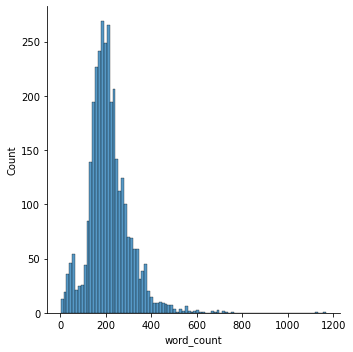

In [ ]:
#Calculating the word count for book description and adding a new column to the dataframe

import seaborn as sns
import matplotlib.pyplot as plt

books['word_count'] = books['description'].apply(lambda x: len(str(x).split()))  # Plotting the word count
plt.figure(figsize=[12, 10])
sns.displot(books['word_count'])


The book descriptions are not too leangthy. Average length of book descriptions are mostly of 200 words.

In [ ]:
books.head()

,title,author,average_rating,genre,description,word_count
0,To Kill a Mockingbird,Harper Lee,4.27,Classics,The unforgettable novel of a childhood in a sl...,202
1,Pride and Prejudice,Jane Austen,4.27,Classics,Alternate cover edition of ISBN 9780679783268S...,158
2,The Diary of a Young Girl,Anne Frank,4.17,Nonfiction,Discovered in the attic in which she spent the...,232
3,Animal Farm,George Orwell,3.97,Classics,Librarian's note: There is an Alternate Cover ...,187
4,The Little Prince,Antoine de Saint-Exupéry,4.31,Classics,A pilot stranded in the desert awakes one morn...,195


## Data Preprocessing

In [ ]:
books['genre'].unique()

array(['Classics', 'Nonfiction', 'Historical', 'Fantasy', 'Fiction',
       'Young Adult', 'Childrens', 'Science Fiction', 'Poetry', 'Horror',
       'History', 'Mystery', 'Travel', 'Romance', 'Philosophy', 'Science',
       'Sequential Art', 'Christian', 'Academic', 'Self Help', 'Language',
       'Thriller', 'Religion', 'Plays', 'Cultural', 'Contemporary',
       'Drama', 'Autobiography', 'Esoterica', 'Short Stories', 'Crime',
       'Psychology', 'Feminism', 'Christian Fiction', 'Adventure',
       'Biography', 'Food and Drink', 'Spirituality', 'Paranormal',
       'Holiday', 'Novels', 'Epic', 'Inspirational', 'Apocalyptic',
       'Book Club', 'Realistic Fiction', 'Economics', 'Polyamorous',
       'Marriage', 'Education', 'Humor', 'Art', 'Business', 'Politics',
       'Womens Fiction', 'Health', 'New Adult', 'Erotica',
       'Shapeshifters', 'War', 'Design', 'Adult', 'Parenting', 'Gothic',
       'Animals', 'LGBT', 'Modern', 'Literature', 'Magical Realism',
       'Music', 'Dark'

In [ ]:
#filtering #1  books with genres consiting more than 100 books
df = books[books['genre'].map(books['genre'].value_counts()) > 100]

In [ ]:
df['genre'].value_counts()

Fiction        802
Nonfiction     391
Fantasy        324
Classics       302
Young Adult    182
Historical     159
Mystery        127
Name: genre, dtype: int64

In [ ]:
# creating a sub dataframe of fiction books with  less than 160 word count.
# As description is our main criteria for model accuracy and prediction , we are removing the books which has low word count.
df2 = df[(df.genre == 'Fiction') & (df.word_count <= 160)]
# dropping the  rows created in df2 from the df column.
df.drop(df2.index,axis=0,inplace=True)

In [ ]:
df.genre.value_counts()
# Updated genre count.

Fiction        598
Nonfiction     391
Fantasy        324
Classics       302
Young Adult    182
Historical     159
Mystery        127
Name: genre, dtype: int64

array([<AxesSubplot:ylabel='genre'>], dtype=object)

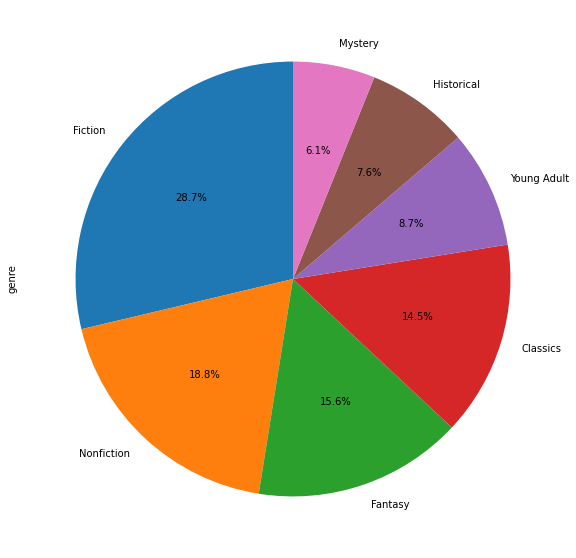

In [ ]:
df.genre.value_counts().plot(kind='pie', subplots=True, startangle=90,
figsize=(15,10), autopct='%1.1f%%')

In [ ]:
# Label encoding the Class column : Abusive = 0 and Non Abusive = 1

le = preprocessing.LabelEncoder()
le_fit = le.fit_transform(df.genre)
df['genre_le'] = le.fit

In [ ]:
le_fit

array([0, 0, 5, ..., 2, 1, 1])

In [ ]:
df.genre.unique()
df.head()


NameError: name 'df' is not defined

In [ ]:
df['author'] = df['author'].str.replace(" ","")
df['tags'] = df['author'] + " " + df['description']
df.drop(['word_count', 'author', 'description'], axis=1, inplace=True)



,title,average_rating,genre,genre_le,tags
0,To Kill a Mockingbird,4.27,Classics,0,harperlee the unforgettable novel of a childho...
1,Pride and Prejudice,4.27,Classics,0,janeausten alternate cover edition of isbn 978...
2,The Diary of a Young Girl,4.17,Nonfiction,5,annefrank discovered in the attic in which she...
3,Animal Farm,3.97,Classics,0,georgeorwell librarian's note: there is an alt...
4,The Little Prince,4.31,Classics,0,antoinedesaint-exupéry a pilot stranded in the...


In [ ]:
#text cleaning,lowercase,removing special characters

def clean_summary(text):
    # removing everything other than alphabets and numbers with spaces
    text = re.sub('\W+', ' ', text)
    text = text.lower()  # converts all the text to lowercase
    return text


In [ ]:
df['tags'] = df['tags'].apply(clean_summary)
df.head()


In [ ]:
#stemming
ps = PorterStemmer()

In [ ]:
def stemming(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [ ]:
df['tags'] = df['tags'].apply(stemming)
df.head()

,title,average_rating,genre,genre_le,tags
0,To Kill a Mockingbird,4.27,Classics,0,harperle the unforgett novel of a childhood in...
1,Pride and Prejudice,4.27,Classics,0,janeausten altern cover edit of isbn 978067978...
2,The Diary of a Young Girl,4.17,Nonfiction,5,annefrank discov in the attic in which she spe...
3,Animal Farm,3.97,Classics,0,georgeorwel librarian' note: there is an alter...
4,The Little Prince,4.31,Classics,0,antoinedesaint-exupéri a pilot strand in the d...


In [ ]:
# assign the independent features (text) to X variable and the target to y
X = pd.DataFrame(df['tags'])
y = df['genre_le']


In [ ]:
y

0       0
1       0
2       5
3       0
4       0
       ..
3344    2
3345    2
3346    2
3348    1
3351    1
Name: genre_le, Length: 2083, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
y.value_counts()

2    598
5    391
1    324
0    302
6    182
3    159
4    127
Name: genre_le, dtype: int64

In [ ]:
#performing oversampling on all genres except genre class  2
strategy = {0:400, 1:400, 2:598, 3:400, 4:400, 5:400,6:400}
os = RandomOverSampler(sampling_strategy = strategy)

In [ ]:
X_rs, y_rs = os.fit_resample(X,y)

In [ ]:
from collections import Counter
print(Counter(y))


Counter({2: 598, 5: 391, 1: 324, 0: 302, 6: 182, 3: 159, 4: 127})


In [ ]:
print(Counter(y_rs))

Counter({2: 598, 0: 400, 5: 400, 3: 400, 1: 400, 6: 400, 4: 400})


In [ ]:
#performing undersampling on class 2
strategy = {0:400, 1:400, 2:400, 3:400, 4:400,5:400,6:400}
us = RandomUnderSampler(sampling_strategy = strategy)

In [ ]:
X_new, y_new = us.fit_resample(X_rs,y_rs)

In [ ]:
print(Counter(y_new))

Counter({0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400})


<AxesSubplot:>

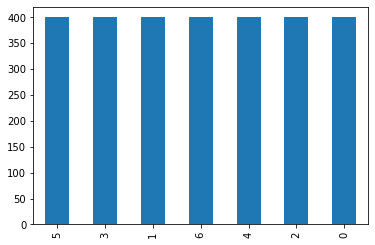

In [ ]:
y_new.value_counts().plot(x='y_new',y = 'count',kind = 'bar')

In [ ]:
y_new.shape

(2800,)

## Split the dataset into Train and Test sets

In [ ]:
#split data into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.20)

In [ ]:
X_train.head()

,tags
2719,"kirstenfullm gloria hasn’t had an easi life, s..."
2259,"edwardabbey first publish in 1968, desert soli..."
2640,jenniferniven the fault in our star meet elean...
1649,agathachristi when alic asher is murder in and...
2159,gregmortenson from the author of the #1 bestse...


In [ ]:
x_train = X_train.iloc[:,0]
x_train.head()

2719    kirstenfullm gloria hasn’t had an easi life, s...
2259    edwardabbey first publish in 1968, desert soli...
2640    jenniferniven the fault in our star meet elean...
1649    agathachristi when alic asher is murder in and...
2159    gregmortenson from the author of the #1 bestse...
Name: tags, dtype: object

## CountVectorizer - Feature Extraction

In [ ]:
#using countvectorizer
cv = CountVectorizer(max_features = 10000)

In [ ]:
x = cv.fit_transform(x_train).toarray()
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]])

In [ ]:
x_test = X_test.iloc[:,0]
x_test.head()

192     kurtvonnegutjr. select by the modern librari a...
2250    clarissapinkolaesté within everi woman there i...
1681    angiekim how far will you go to protect your f...
1467    irvingston lust for life is the classic fictio...
1872    annefrasi for three years, detect jude fontain...
Name: tags, dtype: object

In [ ]:
test_x = cv.transform(x_test).toarray()
test_x.shape

(560, 10000)

## Model Fitting

In [ ]:
# Creating empty lists to store model training time, model predicting time, model accuracy scores, model precision scores.
training_time = []
predicting_time = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [ ]:
model1 = MultinomialNB()

In [ ]:
#train model and predict model training time
t0 = time()
model1.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 1.374 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model1.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 0.062 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))




Accuracy Score 0.8339285714285715
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78        77
           1       0.80      0.89      0.84        76
           2       0.52      0.77      0.62        60
           3       0.94      0.83      0.88        96
           4       0.96      0.96      0.96        70
           5       0.93      0.83      0.87        92
           6       0.85      0.87      0.86        89

    accuracy                           0.83       560
   macro avg       0.84      0.83      0.83       560
weighted avg       0.86      0.83      0.84       560

confusion matrix:
 [[53  5 13  3  0  1  2]
 [ 2 68  0  0  0  0  6]
 [ 1  3 46  1  2  5  2]
 [ 1  2 11 80  0  0  2]
 [ 0  3  0  0 67  0  0]
 [ 2  0 10  1  1 76  2]
 [ 0  4  8  0  0  0 77]]


In [ ]:
model2 = GaussianNB()

In [ ]:
#train model and predict model training time
t0 = time()
model2.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 0.417 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model2.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 0.238 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.7232142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.49      0.61        77
           1       0.77      0.67      0.72        76
           2       0.31      0.62      0.41        60
           3       0.93      0.79      0.85        96
           4       0.99      1.00      0.99        70
           5       0.62      0.70      0.65        92
           6       0.97      0.78      0.86        89

    accuracy                           0.72       560
   macro avg       0.77      0.72      0.73       560
weighted avg       0.79      0.72      0.74       560

confusion matrix:
 [[38  6 23  1  0  8  1]
 [ 3 51 13  0  0  8  1]
 [ 4  3 37  2  1 13  0]
 [ 0  2 13 76  0  5  0]
 [ 0  0  0  0 70  0  0]
 [ 2  2 24  0  0 64  0]
 [ 0  2  9  3  0  6 69]]


In [ ]:
model3 = tree.DecisionTreeClassifier()

In [ ]:
#train model and predict model training time
t0 = time()
model3.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 2.873 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model3.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 0.015 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.6428571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.58      0.54        77
           1       0.55      0.53      0.54        76
           2       0.22      0.17      0.19        60
           3       0.76      0.85      0.80        96
           4       0.84      1.00      0.92        70
           5       0.61      0.41      0.49        92
           6       0.77      0.84      0.80        89

    accuracy                           0.64       560
   macro avg       0.61      0.63      0.61       560
weighted avg       0.62      0.64      0.63       560

confusion matrix:
 [[45  4 11  4  1  8  4]
 [ 9 40  6  8  0  8  5]
 [16 12 10  6  7  5  4]
 [ 7  4  2 82  0  1  0]
 [ 0  0  0  0 70  0  0]
 [ 9 10 14  6  5 38 10]
 [ 4  3  3  2  0  2 75]]


In [ ]:
model5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [ ]:
#train model and predict model training time
t0 = time()
model5.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 0.917 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model5.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 18.849 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.40714285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.82      0.38        77
           1       0.33      0.39      0.36        76
           2       0.10      0.05      0.07        60
           3       0.57      0.43      0.49        96
           4       0.82      0.57      0.67        70
           5       0.67      0.22      0.33        92
           6       0.89      0.35      0.50        89

    accuracy                           0.41       560
   macro avg       0.52      0.40      0.40       560
weighted avg       0.54      0.41      0.41       560

confusion matrix:
 [[63  6  1  3  2  2  0]
 [27 30  5 11  0  2  1]
 [29 12  3  8  2  4  2]
 [37  9  6 41  2  0  1]
 [24  2  2  2 40  0  0]
 [43 11 11  6  1 20  0]
 [30 21  2  1  2  2 31]]


In [ ]:
model6 = LogisticRegression(max_iter=2000)

In [ ]:
#train model and predict model training time
t0 = time()
model6.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 20.459 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model6.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 0.04 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.7964285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        77
           1       0.78      0.78      0.78        76
           2       0.52      0.50      0.51        60
           3       0.85      0.84      0.85        96
           4       0.91      1.00      0.95        70
           5       0.85      0.76      0.80        92
           6       0.81      0.87      0.84        89

    accuracy                           0.80       560
   macro avg       0.78      0.79      0.78       560
weighted avg       0.79      0.80      0.79       560

confusion matrix:
 [[59  4  5  3  0  5  1]
 [ 4 59  2  1  0  1  9]
 [ 5  5 30  7  3  6  4]
 [ 4  0  9 81  1  0  1]
 [ 0  0  0  0 70  0  0]
 [ 4  2  7  3  3 70  3]
 [ 1  6  5  0  0  0 77]]


In [ ]:
model7 = SVC(kernel='linear',gamma='auto')

In [ ]:
#train model and predict model training time
t0 = time()
model7.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 67.087 s



In [ ]:
# Predict using the trained model
t1 = time()
predicted = model7.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 11.414 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.7714285714285715
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70        77
           1       0.70      0.72      0.71        76
           2       0.49      0.60      0.54        60
           3       0.90      0.84      0.87        96
           4       0.93      1.00      0.97        70
           5       0.82      0.68      0.75        92
           6       0.81      0.83      0.82        89

    accuracy                           0.77       560
   macro avg       0.77      0.77      0.76       560
weighted avg       0.78      0.77      0.77       560

confusion matrix:
 [[53  8  8  2  0  5  1]
 [ 6 55  3  2  0  2  8]
 [ 5  6 36  2  3  5  3]
 [ 3  0  9 81  0  2  1]
 [ 0  0  0  0 70  0  0]
 [ 6  5 11  2  1 63  4]
 [ 1  5  7  1  1  0 74]]


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

# create model
def create_model():
    model8 = Sequential()
    model8.add(Dense(10, input_dim=10000, kernel_initializer='uniform', activation='relu'))
    model8.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model8.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model8

# Create the model

model8 = KerasClassifier(build_fn=create_model,verbose = 0, batch_size = 10, epochs = 50 )

In [ ]:
t0 = time()
nn = model8.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 8.571 s



In [ ]:
t1 = time()
pred = model8.predict(test_x).round(1) 
predicting_time.append(round(time()-t1, 3))

print(pred[0:5]) 


[[1]
 [1]
 [1]
 [1]
 [1]]


In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,pred))

accuracy_scores.append(accuracy_score(y_test,pred).round(2))

print("Classification Report:\n",classification_report(y_test, pred))
clf_rep = precision_recall_fscore_support(y_test,pred)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, pred))



Accuracy Score 0.1357142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.14      1.00      0.24        76
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        96
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00        92
           6       0.00      0.00      0.00        89

    accuracy                           0.14       560
   macro avg       0.02      0.14      0.03       560
weighted avg       0.02      0.14      0.03       560

confusion matrix:
 [[ 0 77  0  0  0  0  0]
 [ 0 76  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0 96  0  0  0  0  0]
 [ 0 70  0  0  0  0  0]
 [ 0 92  0  0  0  0  0]
 [ 0 89  0  0  0  0  0]]


In [ ]:
model4 = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
#train model and predict model training time
t0 = time()
model4.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 0.63 s



In [ ]:
# Predit using the trained model
t1 = time()
predicted = model4.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

Predicting time: 0.037 s



In [ ]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.44107142857142856
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51        77
           1       0.60      0.53      0.56        76
           2       0.16      0.57      0.25        60
           3       0.69      0.23      0.34        96
           4       0.53      0.77      0.63        70
           5       0.92      0.26      0.41        92
           6       0.69      0.38      0.49        89

    accuracy                           0.44       560
   macro avg       0.59      0.46      0.46       560
weighted avg       0.62      0.44      0.46       560

confusion matrix:
 [[39  2 32  0  3  0  1]
 [ 6 40 17  3  5  0  5]
 [ 8  3 34  1 13  1  0]
 [11  4 49 22  8  1  1]
 [ 0  0 11  0 54  0  5]
 [ 8  7 32  5 13 24  3]
 [ 4 11 33  1  6  0 34]]


In [ ]:
model_name = ['Multinomial Bayes','Gaussian Bayes','Decision Tree','RandomForest','KNN','Logistic Regression','SVM','Neural Network']

In [ ]:
performance_table = pd.DataFrame({'Model_name' : model_name,
                            'Training time' : training_time,
                            'Prediction time' : predicting_time,
                            'Accuracy' : accuracy_scores,
                            'Precision' : precision_scores,
                            'Recall' : recall_scores,
                            'F1-scores' : f1_scores}).sort_values('F1-scores',ascending=False)

In [ ]:
performance_table

,Model_name,Training time,Prediction time,Accuracy,Precision,Recall,F1-scores
0,Multinomial Bayes,1.374,0.062,0.83,0.90,0.69,0.78
4,KNN,20.459,0.040,0.80,0.77,0.77,0.77
5,Logistic Regression,67.087,11.414,0.77,0.72,0.69,0.70
1,Gaussian Bayes,0.417,0.238,0.72,0.81,0.49,0.61
2,Decision Tree,2.873,0.015,0.64,0.50,0.58,0.54
7,Neural Network,0.630,0.038,0.44,0.51,0.51,0.51
3,RandomForest,0.917,18.849,0.41,0.25,0.82,0.38
6,SVM,8.572,0.109,0.14,0.00,0.00,0.00


## Model Prediction

In [ ]:
rec = ["A comet the color of blood and flame cuts across the sky. Two great leaders—Lord Eddard Stark and Robert Baratheon—who hold sway over an age of enforced peace are dead, victims of royal treachery. Now, from the ancient citadel of Dragonstone to the forbidding shores of Winterfell, chaos reigns. Six factions struggle for control of a divided land and the Iron Throne of the Seven Kingdoms, preparing to stake their claims through tempest, turmoil, and war."]

In [ ]:
t = cv.transform(rec).toarray()

In [ ]:
pr = le.inverse_transform(model1.predict(t))


In [ ]:
pr[0]

'Fantasy'

## Predicting Recommendation

In [ ]:
def recommend(genre):
    recommended_books = df[df['genre'] == genre].sort_values(by = 'average_rating',ascending = False).head()
    print(recommended_books.title)
        
    return
    

In [ ]:
recommend('Fantasy')

3226                                     The High Auction
1491    A Song of Ice and Fire (A Song of Ice and Fire...
695                                  Adhaata Asao's Liege
11                   Harry Potter and the Deathly Hallows
3020      Kargaroth: A Tale of the Great Onion Knighthood
Name: title, dtype: object


## Exporting PKL files

In [ ]:
import pickle

pickle.dump(model1,open('model.pkl','wb'))
pickle.dump(df,open('books.pkl','wb'))
pickle.dump(cv,open('CountVectorizer.pkl','wb'))